In [4]:
%pylab inline
from sigvisa import Sigvisa
from sigvisa.source.event import get_event, Event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_from, do_inference
from sigvisa.infer.correlations.event_proposal import correlation_location_proposal, generate_historical_db
from sigvisa.infer.correlations.ar_correlation_model import estimate_ar, ar_advantage, iid_advantage

from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov

import os, sys, traceback
import cPickle as pickle

stas = ['ASAR', 'KURK', 'MKAR', 'SONM', 'BVAR', 'FITZ', 'CTA', 'CMAR', 'WRA', 'ZALV', 'MJAR', 'AKTO', 'INK']

doublet = 5334939

evids = [5334501, 5334991, 5334726, 5335144, 5349684, 5335822, 5348178, 5334971, 5349536, 5335079, 5335116, 5335138, 5350499, 5336237, 5335425, 5335424, 5349441, 5336640, 5335577, 5350077, 5336889, 5335760, 5336967, 5337111, 533\
6015, 5337461, 5351821, 5351657, 5336724, 5351713, 5338302, 5338318, 5338388]


Populating the interactive namespace from numpy and matplotlib


In [9]:
import cPickle as pickle
with open("/home/dmoore/python/sigvisa/logs/mcmc/00276/step_000574/pickle.sg", "rb") as f:
    sg = pickle.load(f)

166


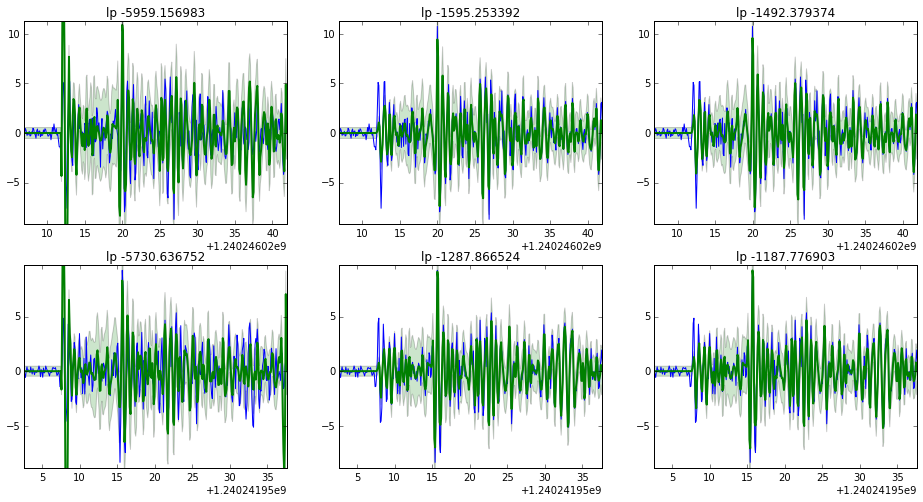

In [14]:
import matplotlib.gridspec as gridspec

sta="MK31"
phase="P"

(starray, etarray, idarray, M, levels, N)= sg.station_waves.values()[0][0].wavelet_basis
prototypes = [np.asarray(m).flatten() for m in M]
n_basis = np.sum(levels[:-1])
print n_basis

eids = sg.evnodes.keys()


wiggle_gpmodels = dict([(k, v) for (k, v) in sg._joint_gpmodels[sta].items() if k[0].startswith("db")])

n = len(eids)
f = plt.figure(figsize=(16, 4*n))
f.patch.set_facecolor('white')
gs = gridspec.GridSpec(n, 3)

j = 0
for wn in sg.station_waves[sta]:
    wn._parent_values()

    tssm = wn.transient_ssm()
    npts = wn.npts
    base_mean = tssm.mean_obs(npts)
    base_var = tssm.obs_var(npts)

    w = wn.get_value()
    lp1, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(w)
    srate = wn.srate
    stime = wn.st
    timevals = np.arange(stime, stime + npts / srate, 1.0 / srate)[0:npts]

    posterior_means, posterior_vars = zip(*marginals)
    posterior_means, posterior_vars = np.concatenate(posterior_means), np.concatenate(posterior_vars)


    for i, (eid, pphase, _, sidx, cnpts, ctype) in enumerate(wn.tssm_components):
        if ctype != "wavelet": continue
        if pphase != phase: continue

        cond_means, cond_vars = zip(*[jgp.posterior(eid) for jgp in wn.wavelet_param_models[phase]])
        cond_means, cond_vars = np.asarray(cond_means, dtype=np.float64), np.asarray(cond_vars, dtype=np.float64)
        cssm = wn.arrival_ssms[(eid, phase)]
        cssm.set_coef_prior(cond_means, cond_vars)

        pred_mean = tssm.mean_obs(npts)
        pred_var = tssm.obs_var(npts)
        lp2 = tssm.run_filter(w)


        posterior_means[n_basis:] = 0.0
        posterior_vars[n_basis:] = 1.0
        cssm.set_coef_prior(posterior_means, posterior_vars)
        post_mean = tssm.mean_obs(npts)
        post_var = tssm.obs_var(npts)
        lp3 = tssm.run_filter(w)


        cstime = stime + sidx/srate - 5.0
        cetime= cstime + cnpts / srate + 5.0

        ax = f.add_subplot(gs[j, 0])
        ax.plot(timevals, w)
        ax.plot(timevals, pred_mean, lw=2)
        #ax.plot(timevals, pred_mean+np.sqrt(pred_var))

        ax.fill_between(timevals, pred_mean+2*np.sqrt(pred_var),
                        pred_mean-2*np.sqrt(pred_var), facecolor="green", alpha=0.2)

        ax.set_xlim([cstime, cetime])
        ax.set_ylim([np.min(w)-.5, np.max(w)+.5])

        ax.set_title("lp %f" % (lp2))
        ax = f.add_subplot(gs[j, 1])
        #plot_wavelet_dist_samples(ax, wn.srate, basis, posterior_means, posterior_vars, c="blue")
        #plot_wavelet_dist_samples(ax, wn.srate, basis, cond_means, cond_vars, c="green")
        ax.plot(timevals, w)
        ax.plot(timevals, base_mean, lw=2)
        ax.fill_between(timevals, base_mean+2*np.sqrt(base_var),
                        base_mean-2*np.sqrt(base_var), facecolor="green", alpha=0.2)

        ax.set_xlim([cstime, cetime])
        ax.set_ylim([np.min(w)-.5, np.max(w)+.5])
        ax.set_title("lp %f" % (lp1))


        ax = f.add_subplot(gs[j, 2])
        #plot_wavelet_dist_samples(ax, wn.srate, basis, posterior_means, posterior_vars, c="blue")
        #plot_wavelet_dist_samples(ax, wn.srate, basis, cond_means, cond_vars, c="green")
        ax.plot(timevals, w)
        ax.plot(timevals, post_mean, lw=2)
        ax.fill_between(timevals, post_mean+2*np.sqrt(post_var),
                        post_mean-2*np.sqrt(post_var), facecolor="green", alpha=0.2)

        ax.set_xlim([cstime, cetime])
        ax.set_title("lp %f" % (lp3))
        ax.set_ylim([np.min(w)-.5, np.max(w)+.5])
        j += 1

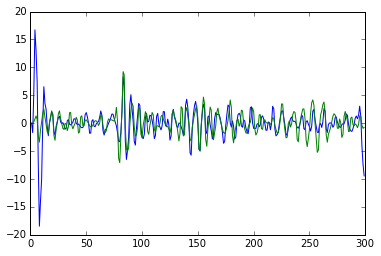

In [18]:
plot(pred_mean[300:600])
plot(post_mean[300:600])

In [24]:
jgp1 = wn.wavelet_param_models[phase][0]
print eid
jgp1.posterior(eid)

2


(169789.19990624377, array([ 1.]))

In [32]:
jgp1._cached_gp.keys()
gp1 = jgp1.train_gp(holdout_eid=2)
evdict = jgp1.evs[2]
x = jgp1._ev_features(evdict)
print x

{'lat': -4.1037, 'depth': 25.5, 'lon': 129.6508, 'mb': 3.9608056}
[ 129.6508      -4.1037      25.5          0.           3.9608056]


In [34]:
gp1.X

matrix([[ 129.6193   ,   -4.1387   ,   36.       ,    0.       ,
            4.1739301]])

In [39]:
gp1.y_obs_variances

array([  3.26704902e+08])

In [41]:
gp1.predict(x.reshape(1, -1))

169789.19990624377